In [21]:
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from unet import unet_model

In [9]:
image_directory = 'data/training/'
mask_directory = 'data/ground_truth/'
SIZE = 256
image_dataset = []
mask_dataset = []

images = os.listdir(image_directory)
for i, image_name in enumerate(images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))


In [10]:
# Normalise the training images. The images are in 0-255 range with 3 channels
# 1600, 256, 256, 1
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1), 3)
# Do not normalize the masks, just rescale them to 0-1 range, because they do not have 3 colour channels.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.10, random_state=0)

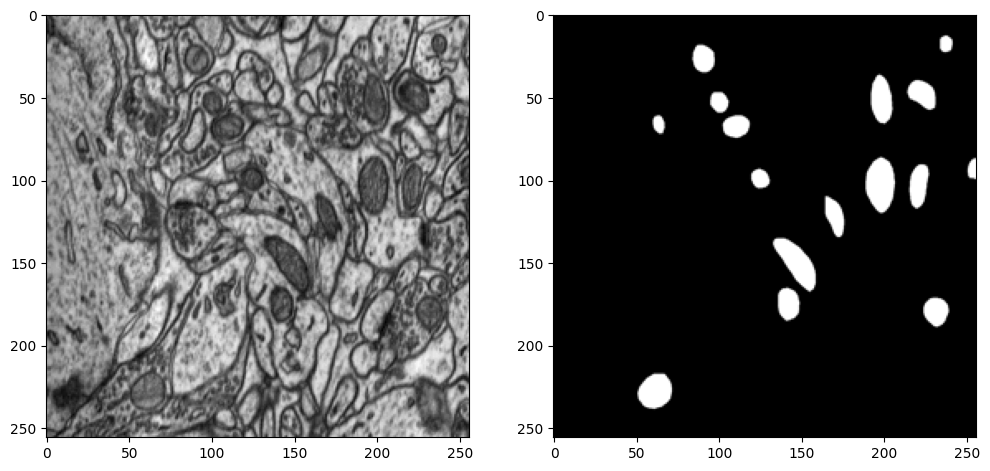

In [18]:
# Check things are working correctly
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

In [23]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

def get_model():
    return unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = get_model()

2023-03-16 15:50:18.633514: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-16 15:50:18.633834: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
             

In [ ]:
# Can load the model:
# model.load_weights('mitochondria_test.hdf5')

In [41]:
history = model.fit(
    X_train,
    y_train,
    batch_size=16,
    verbose=1,
    epochs=50,
    validation_data=(X_test, y_test),
    shuffle=False
)

model.save('mitochondria_test.hdf5')

Epoch 1/50
10/10 [==============================] - 3s 226ms/step - loss: 0.0850 - accuracy: 0.9428 - val_loss: 0.0821 - val_accuracy: 0.9574
Epoch 2/50
10/10 [==============================] - 2s 221ms/step - loss: 0.0686 - accuracy: 0.9615 - val_loss: 0.0622 - val_accuracy: 0.9633
Epoch 3/50
10/10 [==============================] - 2s 222ms/step - loss: 0.0504 - accuracy: 0.9691 - val_loss: 0.0592 - val_accuracy: 0.9669
Epoch 4/50
10/10 [==============================] - 2s 220ms/step - loss: 0.0417 - accuracy: 0.9725 - val_loss: 0.0513 - val_accuracy: 0.9707
Epoch 5/50
10/10 [==============================] - 2s 220ms/step - loss: 0.0352 - accuracy: 0.9749 - val_loss: 0.0509 - val_accuracy: 0.9694
Epoch 6/50
10/10 [==============================] - 2s 220ms/step - loss: 0.0367 - accuracy: 0.9742 - val_loss: 0.0458 - val_accuracy: 0.9734
Epoch 7/50
10/10 [==============================] - 2s 221ms/step - loss: 0.0326 - accuracy: 0.9758 - val_loss: 0.0351 - val_accuracy: 0.9750
Epoch 

In [43]:
# Check model accuracy
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

1/1 [==============================] - 0s 134ms/step - loss: 0.0250 - accuracy: 0.9783
Accuracy =  97.83082604408264 %


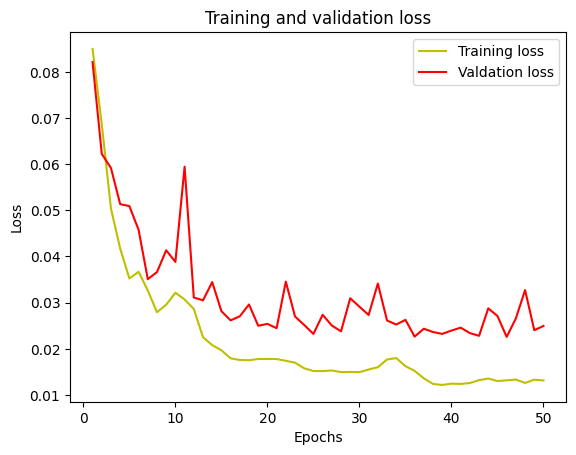

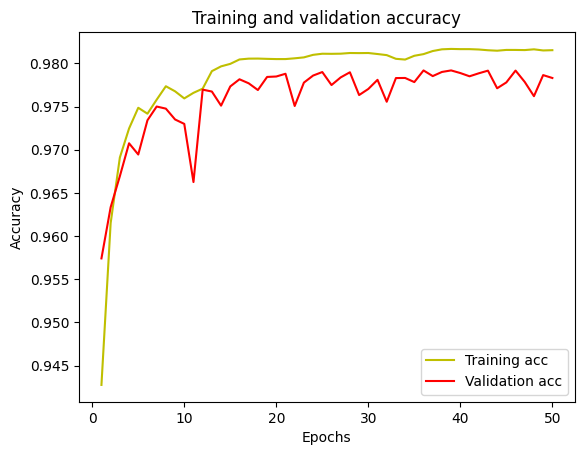

In [44]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Valdation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [42]:
# Note that for semantic segmentation, accuracy is not the correct metric.

# Calculate IOU
y_pred = model.predict(X_test)
y_pred_thresholded = y_pred > 0.5 # this value is a probability cutoff

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print(f"IoU score: {iou_score}")

1/1 [==============================] - 0s 44ms/step
IoU score: 0.8433349503743232


1/1 [==============================] - 0s 12ms/step


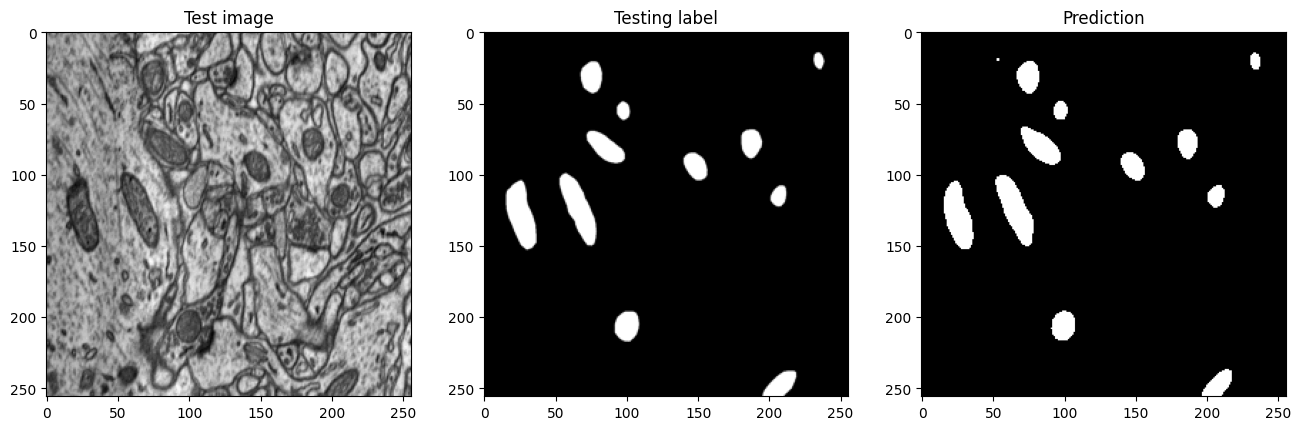

In [50]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:, :, 0][:, :, None]
test_img_input = np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0, :, :, 0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.title('Test image')
plt.imshow(test_img[:, :, 0], cmap='gray')
plt.subplot(132)
plt.imshow(ground_truth[:, :, 0], cmap='gray')
plt.title('Testing label')
plt.subplot(133)
plt.imshow(prediction, cmap='gray')
plt.title('Prediction')
plt.show()